# Verification of terminal digits test

Verification of the terminal digits test.
In this case the three colony counts are considered independent
extrations.
The hypotesis is that the last digit of each count can be modeled
as a draw from a uniform distribution.

DELETEME: (This version uses the same data import of the other tests - pandas...)

In [91]:
# import numpy and matlab plot library

import numpy as np

%matplotlib inline 

import matplotlib
import matplotlib.pyplot as plt


import scipy
import scipy.stats as stats

# import panda
import pandas as pd

In [92]:
#DELETEME - only one needed in the final notebook
## List of Functions

# This function takes an N by 3 matrix, sorts the matrix row wise, and then computes the ratio of (mid-min)/(max-min)
# for each row (excludes the rows with all equal entries.)
def compute_ratio(M):
    M.sort(axis=1)
    if (M.shape[1]!=3):
        print 'Size is flawed '
        print M.shape
        
    mid_min = M[:, 1] - M[:, 0]
    max_min = M[:, 2] - M[:, 0]
    ratio = ([mid_min[t]/max_min[t] for t in range(max_min.shape[0]) if max_min[t] !=0 ])
    return np.asarray(ratio)

# This function returns a list of last digits for an np array/ndarray input, and ignores the NAN values
def compute_last_digit(n_arr):
    n_arr = n_arr.flatten()
    return [int (n%10) for n in n_arr if not(np.isnan(n))]

# This function returns a list of last two digits for an np array/ndarray input 
# only for samples with more than 3 digits, 
# and ignores the NAN values.
# Saves it as a string
def compute_last_two_digits(n_arr):
    n_arr = n_arr.flatten()
    return ['%02d'%int(n%100) for n in n_arr if not(np.isnan(n)) and n > 99]

# This function takes a list of strings representing the last two digits and builds a simple 1-0 list 
# representing the equality of the last two digits:
# out[i] = 1 if n_list[i] has equal digits, 0 otherwise
def compute_last_two_digits_binary(n_list):
    return [1 if n[0]==n[1] else 0 for n in n_list]

# This function simply plots a histogram of the data (named ratio) with a given title and displays it inline.
def plot_np_hist(ratio, s='Title', show=False):
    plt.hist(ratio, bins=10, normed = False)
    plt.title(s)
    if show:
        plt.show()

# The next two functions are for obtaining histograms that look similar to the ones given in the paper. In these versions
# since we have to include the right hand edge, I do it manually - both the computation and the plotting of the bars.
def compute_my_histogram(ratio):
    v = np.zeros(10)
    N = len(ratio)
    v[0] = np.sum([( x <= 0.1) for x in ratio])
    for i in range(2, 11):
        thr = float(i) /10.
        v[i-1] = np.sum([( x <= thr and x > thr-0.1) for x in ratio])
    v /= np.sum(v)
    return v
def plot_my_histogram(v, s='Title', show=False):
    x = np.linspace(0,1,10,endpoint=False)
    plt.bar(x, v, width=0.1)
    plt.title(s)
    if show:
        plt.show()

In [ ]:
# Permutation Test Set Ups : We use three different test statistics, namely difference in std deviation, l1-distance
# between the two densities, and l1-distance between the two CDFs.

# Compute the difference between std deviation of two datasets
def std_diff(v1, v2):
    return np.abs(np.std(v1)-np.std(v2))

# Computes the l1 distance between empirical densities of two datasets by computing normalized empirical histogram
def density_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    return np.sum(np.abs(counts1-counts2))

# Computes the l1 distance between empirical CDFs of two datasets by computing normalized empirical histogram
def cdf_distance(v1, v2):
    counts1, _ = np.histogram(v1, bins=10, density=True)
    counts1 /= np.sum(counts1)
    c1 = np.cumsum(counts1)
    counts2, _ = np.histogram(v2, bins=10, density=True)
    counts2 /= np.sum(counts2)
    c2 = np.cumsum(counts2)
    return np.sum(np.abs(c1-c2))

# Performs permutation test by treating xs as the treatment group, and ys as the control group, the local variable zs
# denote the pooled data, and random.shuffle is used to create bootstrapped version of treatment and control groups.
# The function returns the p-value, test-statistic, and all the simulated random values of the test-statistic which 
# are later used to plot histograms for visualization of data by naked eye.
def exact_mc_perm_test(xs, ys, nmc, test_fun=std_diff):
    n, k = len(xs), 0
    diff = test_fun(xs, ys)
    zs = np.concatenate([xs, ys])
    ts = np.zeros(nmc)
    for j in range(nmc):
        np.random.shuffle(zs)
        ts[j] = test_fun(zs[:n],zs[n:])
        k += diff < ts[j]
    return float(k)/nmc , diff, ts

# This function simply reduces the culttering of ticks on x and y axis for clarity.
def pretty_plots(ax, v, name):
    max_yticks = 5
    max_xticks = 5
    plot_np_hist(v, name)
    yloc = plt.MaxNLocator(max_yticks)
    xloc = plt.MaxNLocator(max_xticks)
    ax.yaxis.set_major_locator(yloc)
    ax.xaxis.set_major_locator(xloc)
    
nmc = 1000

In [93]:
# Load the datasets, with the investigator label for the data of the other labmates.

rts_colony_df = pd.read_excel("data/Bishayee Colony Counts 10.27.97-3.8.01.xlsx", 
                              na_values = [' '], skiprows=[0,1], parse_cols = ("D:F"), header = 0)   

rest_colony_df = pd.read_excel("data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.xlsx", 
                               na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:F"))

out3_colony_df = pd.read_excel("data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("B:D"))

rts_coulter_df = pd.read_excel("data/Bishayee Coulter Counts.10.20.97-7.16.01.xlsx", 
                               na_values = [' '], skiprows=[0], parse_cols = ("C:E"), header = 0)   

rest_coulter_df = pd.read_excel("data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("C:E,G"))

out1_coulter_df = pd.read_excel("data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.xlsx", 
                                na_values = [' '], header = None, skiprows = [0], parse_cols = ("B:D"))

out2_coulter_df = pd.read_excel("data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.xlsx", 
                                na_values = [' '], header = 0, skiprows = [0], parse_cols = ("B:D"))



In [94]:
print rts_colony_df.values[0:3,:]
print rest_colony_df.values[0:3,:]
print out3_colony_df.values[0:3,:]
print rts_coulter_df.values[0:3,:]
print rest_coulter_df.values[0:3,:]
print out1_coulter_df.values[0:3,:]
print out2_coulter_df.values[0:3,:]

#pool_coulter = np.vstack([rts_coulter_df.values, rest_coulter_df.values[:,0:3], out1_coulter_df, out2_coulter_df])
#pool_colony = np.vstack([rts_colony_df.values, rest_colony_df.values[:,1:4], out3_colony_df])
#pool_all = np.vstack([pool_coulter, pool_colony])

#print pool_coulter[0:3,:]
#print pool_colony[0:3,:]
#print pool_all[0:3,:]

[[ 78.  91.  93.]
 [ 90.  88.  90.]
 [ 80.  66.  69.]]
[[u'I' 266 247.0 262.0]
 [u'I' 170 151.0 156.0]
 [u'I' 66 66.0 56.0]]
[[54 55 59]
 [47 60 47]
 [55 60 53]]
[[ 531.  508.  541.]
 [ 650.  626.  595.]
 [ 460.  455.  468.]]
[[1547.0 1574.0 1523.0 u'I']
 [1617.0 1552.0 1570.0 u'I']
 [1258.0 1279.0 1284.0 u'I']]
[[ 2266.  2321.  2192.]
 [  676.   554.   478.]
 [  601.   723.   520.]]
[[5868 5838 5691]
 [3451 3343 3315]
 [4844 4854 4695]]


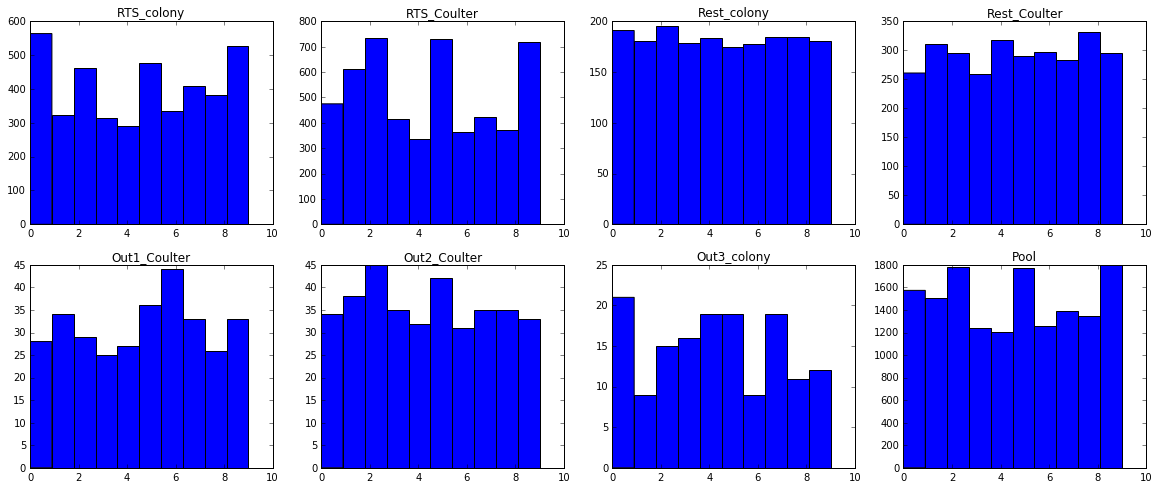

In [95]:
# In this section we plot the distribution of last digit for RTS, Rest and All of them pooled together for the Coulter
# Data. We ignore the NAN values

# Compute the last digit distribution
rld = compute_last_digit(rts_coulter_df.values)
rc_ld = compute_last_digit(rts_colony_df.values)
rest_ld = compute_last_digit(rest_coulter_df.values[:,0:3])
restc_ld = compute_last_digit(rest_colony_df.values[:,1:4])
out1_ld = compute_last_digit(out1_coulter_df.values)
out2_ld = compute_last_digit(out2_coulter_df.values)
out3_ld = compute_last_digit(out3_colony_df.values)
pool_ld = np.concatenate([rld, rc_ld, rest_ld, restc_ld, out1_ld, out2_ld, out3_ld])

# Now Plot
plt.figure(figsize=[20,8])
plt.subplot(241)
plot_np_hist(rc_ld, 'RTS_colony')
plt.subplot(242)
plot_np_hist(rld, 'RTS_Coulter')
plt.subplot(243)
plot_np_hist(restc_ld, 'Rest_colony')
plt.subplot(244)
plot_np_hist(rest_ld, 'Rest_Coulter')
plt.subplot(245)
plot_np_hist(out1_ld, 'Out1_Coulter')
plt.subplot(246)
plot_np_hist(out2_ld, 'Out2_Coulter')
plt.subplot(247)
plot_np_hist(out3_ld, 'Out3_colony')
plt.subplot(248)
plot_np_hist(pool_ld, 'Pool')

plt.show()

In [96]:
#ChiSquare test to match frequencies wrt terminal digits.
#DELETEME Is this OK using scipy.stats.chisquare or is it better to do it manually (see python files)?
#altenatively build
#chi_val = 0
#for f in freq:
#    chi_val = chi_val + ( (f - exp_freq) ** 2) / exp_freq
#p_val = sp.stats.chisqprob(chi_val, DF)

#build convenience dictionaries
names = ('RTS_Coulter', 'RTS_Colony', 'Rest_Coulter', 'Rest_Colony', 'Out1_Coulter', 'Out2_Coulter', 'Out3_Colony')
data = (rld, rc_ld, rest_ld, restc_ld, out1_ld, out2_ld, out3_ld)

datamap = {name: d for (name, d) in zip(names, data)}
exp_freq_ld = dict.fromkeys(names, None)
hist_ld = dict.fromkeys(names, None)
chi2_ld = dict.fromkeys(names, None)


for name in names:
    #Expected frequencies
    exp_freq_ld[name] = np.array([len(datamap[name])/10 for _ in range(10)])
    
    #build frequencies histograms for each group
    hist_ld[name] = np.histogram(datamap[name], range(10 + 1))
    
    #perform chi-square test
    chi2_ld[name] = stats.chisquare(hist_ld[name][0], exp_freq_ld[name])
    

#table 3 results
print 'Name \t\t 0 \t 1 \t 2 \t 3 \t 4 \t 5 \t 6 \t 7 \t 8 \t 9 \t total \t chi-square \t P \t'

for name in names:
    print '%s \t %s \t %d \t %g \t %g' % (name,
                                          ' \t '.join(map(str, hist_ld[name][0])), 
                                          sum(hist_ld[name][0]), chi2_ld[name][0], 
                                          chi2_ld[name][1])

Name 		 0 	 1 	 2 	 3 	 4 	 5 	 6 	 7 	 8 	 9 	 total 	 chi-square 	 P 	
RTS_Coulter 	 475 	 613 	 736 	 416 	 335 	 732 	 363 	 425 	 372 	 718 	 5185 	 467.33 	 5.64306e-95
RTS_Colony 	 564 	 324 	 463 	 313 	 290 	 478 	 336 	 408 	 383 	 526 	 4085 	 200.978 	 2.06634e-38
Rest_Coulter 	 261 	 311 	 295 	 259 	 318 	 290 	 298 	 283 	 331 	 296 	 2942 	 16.0068 	 0.0667397
Rest_Colony 	 191 	 181 	 195 	 179 	 184 	 175 	 178 	 185 	 185 	 181 	 1834 	 1.80328 	 0.99421
Out1_Coulter 	 28 	 34 	 29 	 25 	 27 	 36 	 44 	 33 	 26 	 33 	 315 	 9.70968 	 0.374496
Out2_Coulter 	 34 	 38 	 45 	 35 	 32 	 42 	 31 	 35 	 35 	 33 	 360 	 4.94444 	 0.839124
Out3_Colony 	 21 	 9 	 15 	 16 	 19 	 19 	 9 	 19 	 11 	 12 	 150 	 12.1333 	 0.205897


### Comment
Rest_Colony seems having a suspiciously high P-value.
The next section will decompose that value wrt single individuals taking samples

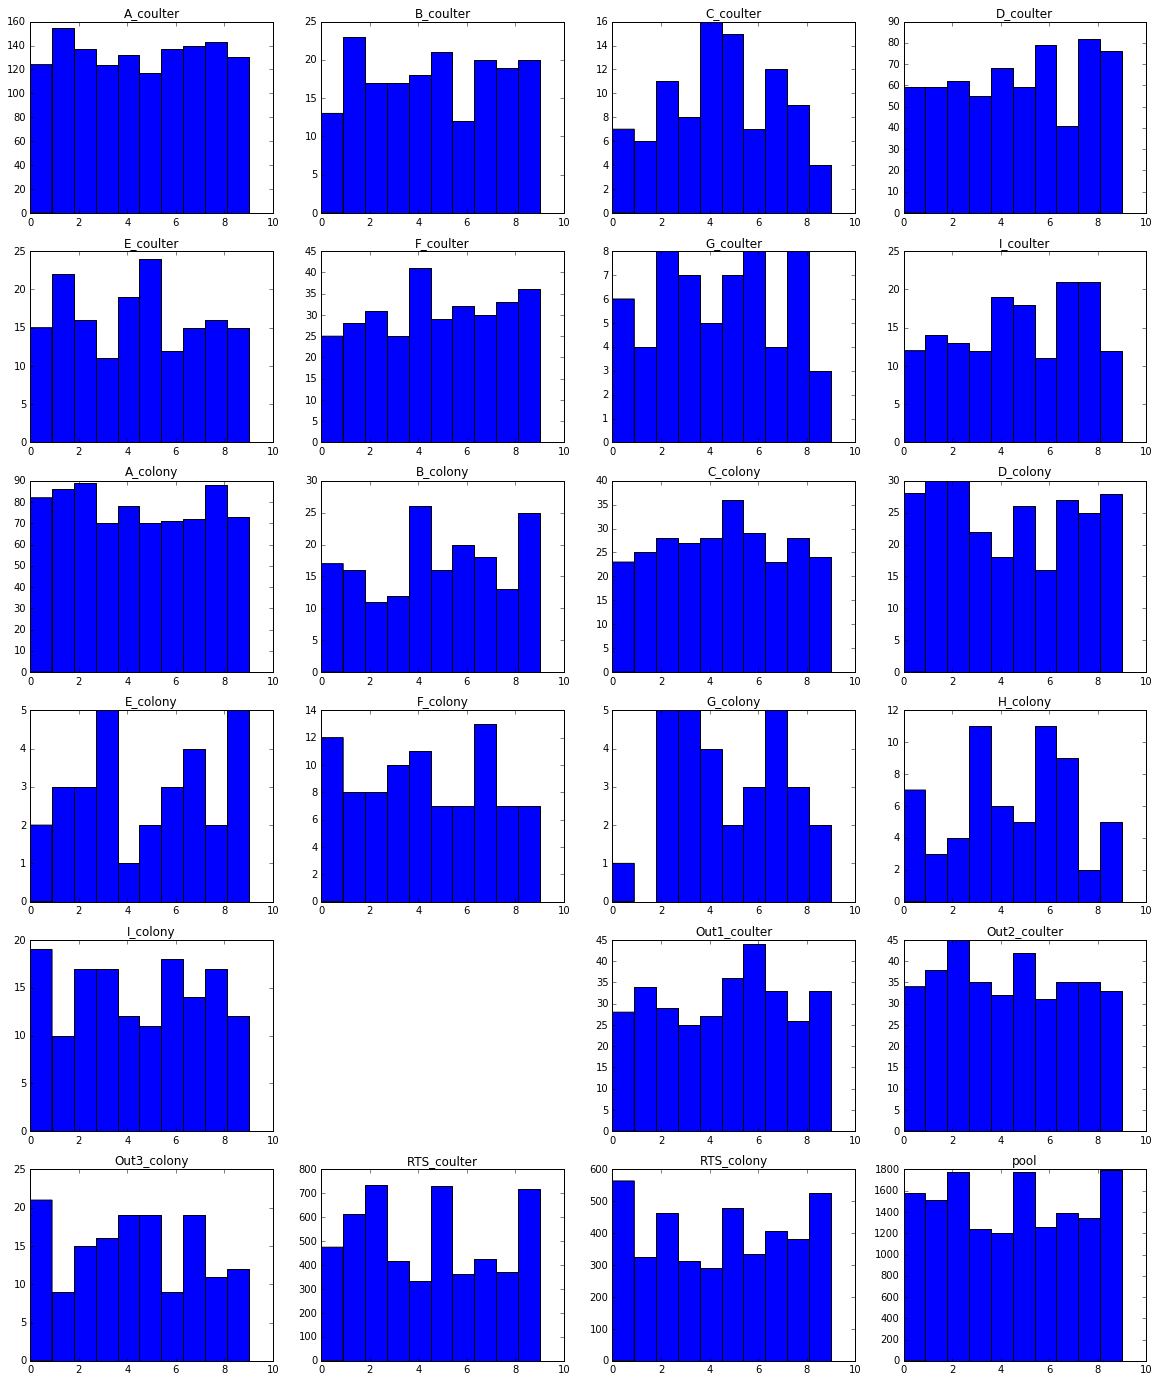

In [97]:
# Terminal digit plots decomposing labmates, 0 to 9, plus outside labs
def cld_val(df):
    return compute_last_digit(df.values[:,0:3])

def cldc_val(df):
    return compute_last_digit(df.values[:,1:4])

rest_grouped_ld = rest_coulter_df.groupby("Investigator").apply(cld_val)

restc_grouped_ld = rest_colony_df.groupby("Inv").apply(cldc_val)

plt.figure(figsize = [20,24])
for j in range(rest_grouped_ld.shape[0]):
    plt.subplot(6,4,j+1)
    plot_np_hist(rest_grouped_ld[j], '%s_coulter' % rest_grouped_ld.index[j])
    
for t in range(restc_grouped_ld.shape[0]):
    plt.subplot(6,4,t+j+2)
    plot_np_hist(restc_grouped_ld[t], '%s_colony' % restc_grouped_ld.index[t])
    

plt.subplot(6,4,19)
plot_np_hist(out1_ld, 'Out1_coulter')
plt.subplot(6,4,20)
plot_np_hist(out2_ld, 'Out2_coulter')
plt.subplot(6,4,21)
plot_np_hist(out3_ld, 'Out3_colony')
plt.subplot(6,4,22)
plot_np_hist(rld, 'RTS_coulter')
plt.subplot(6,4,23)
plot_np_hist(rc_ld, 'RTS_colony')
plt.subplot(6,4,24)
plot_np_hist(pool_ld, 'pool')
plt.show()

In [98]:
#ChiSquare test to match frequencies wrt terminal digits for individual lab partners

#Expected frequencies
ind_coulter_exp_freq = {}
ind_coulter_hist = {}
ind_coulter_chi2 = {}

ind_colony_exp_freq = {}
ind_colony_hist = {}
ind_colony_chi2 = {}

for j in range(rest_grouped_ld.shape[0]):
    ind_coulter_exp_freq[rest_grouped_ld.index[j]] = np.array([len(rest_grouped_ld[j])/10 for _ in range(10)])
    ind_coulter_hist[rest_grouped_ld.index[j]] = np.histogram(rest_grouped_ld[j], range(10 + 1))
    ind_coulter_chi2[rest_grouped_ld.index[j]] = stats.chisquare(ind_coulter_hist[rest_grouped_ld.index[j]][0], ind_coulter_exp_freq[rest_grouped_ld.index[j]])
    
for j in range(restc_grouped_ld.shape[0]):
    ind_colony_exp_freq[restc_grouped_ld.index[j]] = np.array([len(restc_grouped_ld[j])/10 for _ in range(10)])
    ind_colony_hist[restc_grouped_ld.index[j]] = np.histogram(restc_grouped_ld[j], range(10 + 1))
    ind_colony_chi2[restc_grouped_ld.index[j]] = stats.chisquare(ind_colony_hist[restc_grouped_ld.index[j]][0], ind_colony_exp_freq[restc_grouped_ld.index[j]])
    

#table 3 results
print 'Name \t\t 0 \t 1 \t 2 \t 3 \t 4 \t 5 \t 6 \t 7 \t 8 \t 9 \t total \t chi-square \t P \t'

for j in range(rest_grouped_ld.shape[0]):
    print '%s_Coulter \t %s \t %d \t %g \t %g' % (rest_grouped_ld.index[j],
                                                  ' \t '.join(map(str, ind_coulter_hist[rest_grouped_ld.index[j]][0])), 
                                                  sum(ind_coulter_hist[rest_grouped_ld.index[j]][0]), 
                                                  ind_coulter_chi2[rest_grouped_ld.index[j]][0], 
                                                  ind_coulter_chi2[rest_grouped_ld.index[j]][1])
for j in range(restc_grouped_ld.shape[0]):
    print '%s_Colony \t %s \t %d \t %g \t %g' % (restc_grouped_ld.index[j],
                                                  ' \t '.join(map(str, ind_colony_hist[restc_grouped_ld.index[j]][0])), 
                                                  sum(ind_colony_hist[restc_grouped_ld.index[j]][0]), 
                                                  ind_colony_chi2[restc_grouped_ld.index[j]][0], 
                                                  ind_colony_chi2[restc_grouped_ld.index[j]][1])

Name 		 0 	 1 	 2 	 3 	 4 	 5 	 6 	 7 	 8 	 9 	 total 	 chi-square 	 P 	
A_Coulter 	 124 	 155 	 137 	 124 	 132 	 117 	 137 	 140 	 143 	 130 	 1339 	 8.21805 	 0.512331
B_Coulter 	 13 	 23 	 17 	 17 	 18 	 21 	 12 	 20 	 19 	 20 	 180 	 5.88889 	 0.750985
C_Coulter 	 7 	 6 	 11 	 8 	 16 	 15 	 7 	 12 	 9 	 4 	 95 	 15.6667 	 0.0741773
D_Coulter 	 59 	 59 	 62 	 55 	 68 	 59 	 79 	 41 	 82 	 76 	 640 	 21.8438 	 0.00938759
E_Coulter 	 15 	 22 	 16 	 11 	 19 	 24 	 12 	 15 	 16 	 15 	 165 	 9.5625 	 0.387049
F_Coulter 	 25 	 28 	 31 	 25 	 41 	 29 	 32 	 30 	 33 	 36 	 310 	 6.96774 	 0.640478
G_Coulter 	 6 	 4 	 8 	 7 	 5 	 7 	 8 	 4 	 8 	 3 	 60 	 5.33333 	 0.804337
I_Coulter 	 12 	 14 	 13 	 12 	 19 	 18 	 11 	 21 	 21 	 12 	 153 	 9.66667 	 0.378138
A_Colony 	 82 	 86 	 89 	 70 	 78 	 70 	 71 	 72 	 88 	 73 	 779 	 7.1039 	 0.626303
B_Colony 	 17 	 16 	 11 	 12 	 26 	 16 	 20 	 18 	 13 	 25 	 174 	 13.7647 	 0.130945
C_Colony 	 23 	 25 	 28 	 27 	 28 	 36 	 29 	 23 	 28 	 24 	 271 

### Comment
Decomposing data for other investigators shows that the single p-values are less suspiciuos than the p-value of the aggregate data.

## Permutation tests for terminal digits

### Coulter - Std dev


For A, p-value = 0.278000, test-statistic = 0.115587
For B, p-value = 0.901000, test-statistic = 0.123497
For C, p-value = 0.077000, test-statistic = 0.624982
For D, p-value = 0.104000, test-statistic = 0.210235
For E, p-value = 0.441000, test-statistic = 0.242088
For F, p-value = 0.330000, test-statistic = 0.192399
For G, p-value = 0.611000, test-statistic = 0.312605
For I, p-value = 0.231000, test-statistic = 0.324830
For RTS, p-value = 0.000000, test-statistic = 0.236771


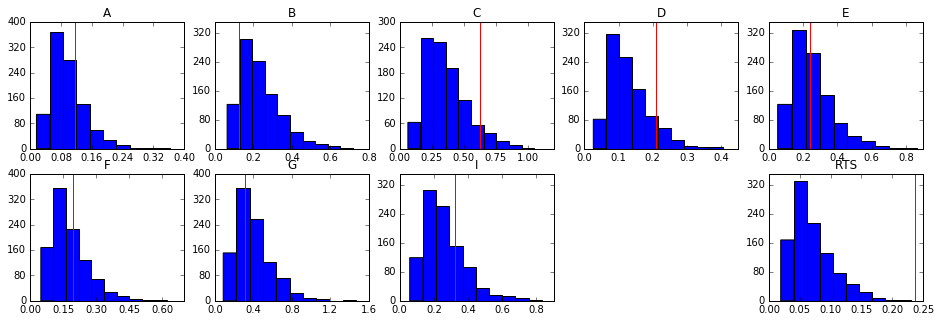

In [114]:
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(cld_val)
rn = np.asarray(rr)
pval, tstat, statmc = exact_mc_perm_test(rld, rest_ld, nmc, cdf_distance)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,rc_ld])
    xs = rn[j]
    std_stat[j] = exact_mc_perm_test(xs, ys, nmc, cdf_distance)
    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, std_stat[j][2], rr.index[j])
    plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
plt.show()
std_stat['RTS']=pval, tstat, statmc

# Equal digits test

In this case the three colony counts are considered independent
extrations.
The hypotesis is that the last pair of digits being equal
(for experiments with at least three digits)
behaves as a draw from a uniform distribution, that is, 10% chance

In [115]:
#build convenience dictionaries

dfs = (rts_coulter_df, rts_colony_df, rest_coulter_df, rest_colony_df, out1_coulter_df, out2_coulter_df, out3_colony_df)
dfmap = {name:df.values for (name,df) in zip(names, dfs)}
dfmap['Rest_Coulter'] = rest_coulter_df.values[:,0:3]
dfmap['Rest_Colony'] = rest_colony_df.values[:,1:4]

td_strings = dict.fromkeys(names, None)
td_binary = dict.fromkeys(names, None)
td_exp_freq = dict.fromkeys(names, None)
td_hist = dict.fromkeys(names, None)
td_chi2 = dict.fromkeys(names, None)

In [116]:
#retrieve data about last two digits

for name in names:
    #compute last two digits in string format
    td_strings[name] = compute_last_two_digits(dfmap[name])
    
    #compute 0-1 list
    td_binary[name] = compute_last_two_digits_binary(td_strings[name])

#print to check format
print td_strings.values()[0][0:10]

#print to check format
print td_binary.values()[0][0:10]

['47', '64', '58', '15', '09', '46', '55', '78', '12', '05']
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [117]:
#build freq expectations, histograms and chi-square tests
#we have only two sets, the terminal digits are the same, or not

for name in names:
    #expected frequencies: 0.9*length zeros, and 0.1*length ones
    td_exp_freq[name] = [len(td_binary[name])*0.9, len(td_binary[name])*0.1]
    
    #histograms
    td_hist[name] = np.histogram(td_binary[name], range(2 + 1))
    
    #chi-square
    td_chi2[name] = stats.chisquare(td_hist[name][0], td_exp_freq[name])

In [118]:
#print table

print 'Name \t\t equal digits \t total \t ratio \t\t chi-square \t P \t'

for name in names:
    print '%s \t %d \t\t %d \t %g \t %g \t %g' % (name,
                                                sum(td_binary[name]),
                                                len(td_binary[name]),
                                                1.*sum(td_binary[name])/len(td_binary[name]),
                                                td_chi2[name][0],
                                                td_chi2[name][1])

Name 		 equal digits 	 total 	 ratio 		 chi-square 	 P 	
RTS_Coulter 	 644 		 5184 	 0.124228 	 33.8121 	 6.0701e-09
RTS_Colony 	 135 		 1660 	 0.0813253 	 6.4324 	 0.0112057
Rest_Coulter 	 286 		 2887 	 0.0990648 	 0.0280568 	 0.866975
Rest_Colony 	 53 		 507 	 0.104536 	 0.115933 	 0.733489
Out1_Coulter 	 32 		 306 	 0.104575 	 0.0711692 	 0.789642
Out2_Coulter 	 30 		 360 	 0.0833333 	 1.11111 	 0.291841
Out3_Colony 	 1 		 7 	 0.142857 	 0.142857 	 0.705457


### Comment
As for the terminal digits, the combined labmates P-value seems a bit high.
The next section analyzes single investigator data

In [119]:
# Equal digits decomposing labmates, 0 to 9
def td_cld_val(df):
    return compute_last_two_digits_binary(compute_last_two_digits(df.values[:,0:3]))

def td_cldc_val(df):
    return compute_last_two_digits_binary(compute_last_two_digits(df.values[:,1:4]))

rest_grouped_td = rest_coulter_df.groupby("Investigator").apply(td_cld_val)
restc_grouped_td = rest_colony_df.groupby("Inv").apply(td_cldc_val)

#filter out empty groups
empty = []
for j in range(rest_grouped_td.shape[0]):
    if len(rest_grouped_td[j])==0:
        empty.append(j)
        
for e in empty:
    print "Investigator %s has no coulter samples with more than 3 digits" % rest_grouped_td.index[e]
    rest_grouped_td = rest_grouped_td.drop(rest_grouped_td.index[e])
    
emptyc = []
for j in range(restc_grouped_td.shape[0]):
    if len(restc_grouped_td[j])==0:
        emptyc.append(j)
        
for e in emptyc:
    print "Investigator %s has no colony samples with more than 3 digits" % restc_grouped_td.index[e]
    restc_grouped_td = restc_grouped_td.drop(restc_grouped_td.index[e])


Investigator G has no colony samples with more than 3 digits


For A, p-value = 0.078000, test-statistic = 0.020220
For B, p-value = 0.158000, test-statistic = 0.036357
For C, p-value = 0.199000, test-statistic = 0.049305
For D, p-value = 0.131000, test-statistic = 0.024356
For E, p-value = 0.481000, test-statistic = 0.024599
For F, p-value = 0.427000, test-statistic = 0.018107
For G, p-value = 0.154000, test-statistic = 0.071193
For I, p-value = 0.032000, test-statistic = 0.062910
For RTS, p-value = 0.000000, test-statistic = 0.031093


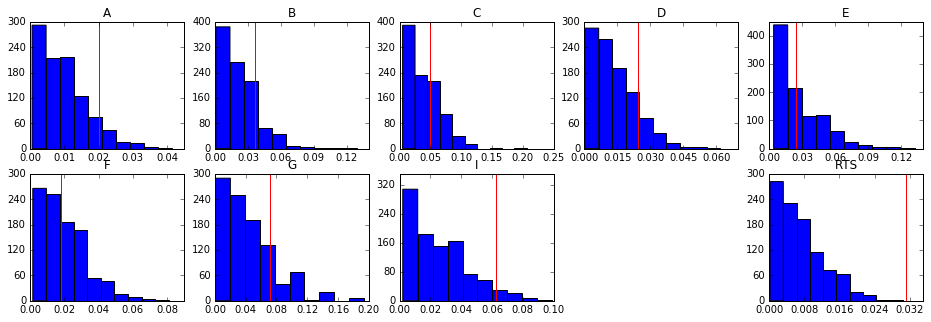

In [133]:
# In this section, Difference between Std Dev is the Test Statistics
rr = rest_coulter_df.dropna(axis=0).groupby("Investigator").apply(td_cld_val)
rn = np.asarray(rr)
#ys = np.hstack([td_binary['Rest_Coulter'],td_binary['RTS_Coulter']])
pval, tstat, statmc = exact_mc_perm_test(td_binary['RTS_Coulter'], td_binary['Rest_Coulter'], nmc)
std_stat = {}
fig = plt.figure(figsize = [16,5])
for j in range(rr.shape[0]):
    ys = np.hstack([rn[t] for t in range(rn.shape[0]) if t!=j])
    ys = np.hstack([ys,td_binary['RTS_Coulter']])
    xs = rn[j]
    std_stat[j] = exact_mc_perm_test(xs, ys, nmc)
    print "For %s, p-value = %f, test-statistic = %f" % (rr.index[j], std_stat[j][0], std_stat[j][1])
    ax = fig.add_subplot(2,5,j+1)
    pretty_plots(ax, std_stat[j][2], rr.index[j])
    plt.axvline(std_stat[j][1], color='r')
ax = fig.add_subplot(2,5,10)
pretty_plots(ax, statmc, 'RTS')
plt.axvline(tstat, color='r')
print "For RTS, p-value = %f, test-statistic = %f" % (pval, tstat)
plt.show()
std_stat['RTS']=pval, tstat, statmc

In [135]:
#ChiSquare test to match frequencies wrt terminal digits for individual lab partners

#Expected frequencies
td_ind_coulter_exp_freq = {}
td_ind_coulter_hist = {}
td_ind_coulter_chi2 = {}

td_ind_colony_exp_freq = {}
td_ind_colony_hist = {}
td_ind_colony_chi2 = {}

for j in range(rest_grouped_td.shape[0]):
    td_ind_coulter_exp_freq[rest_grouped_td.index[j]] = np.array([len(rest_grouped_td[j])*0.9, len(rest_grouped_td[j])*0.1])
    td_ind_coulter_hist[rest_grouped_td.index[j]] = np.histogram(rest_grouped_td[j], range(2 + 1))
    td_ind_coulter_chi2[rest_grouped_td.index[j]] = stats.chisquare(td_ind_coulter_hist[rest_grouped_td.index[j]][0], td_ind_coulter_exp_freq[rest_grouped_td.index[j]])
    
for j in range(restc_grouped_td.shape[0]):
    td_ind_colony_exp_freq[restc_grouped_td.index[j]] = np.array([len(restc_grouped_td[j])*0.9, len(restc_grouped_td[j])*0.1])
    td_ind_colony_hist[restc_grouped_td.index[j]] = np.histogram(restc_grouped_td[j], range(2 + 1))
    td_ind_colony_chi2[restc_grouped_td.index[j]] = stats.chisquare(td_ind_colony_hist[restc_grouped_td.index[j]][0], td_ind_colony_exp_freq[restc_grouped_td.index[j]])
     

#table results
print 'Name \t equal digits \t total \t ratio \t\t chi-square \t P \t'

for j in range(rest_grouped_td.shape[0]):
    print '%s_Coulter \t %d \t %d \t %g \t %g \t %g' % (rest_grouped_td.index[j],
                                                sum(rest_grouped_td[j]),
                                                len(rest_grouped_td[j]),
                                                1.*sum(rest_grouped_td[j])/len(rest_grouped_td[j]),
                                                td_ind_coulter_chi2[rest_grouped_td.index[j]][0],
                                                td_ind_coulter_chi2[rest_grouped_td.index[j]][1])
#print restc_grouped_td

for j in range(restc_grouped_td.shape[0]):
    print '%s_Colony \t %d \t %d \t %g \t %g \t %g' % (restc_grouped_td.index[j],
                                                sum(restc_grouped_td[j]),
                                                len(restc_grouped_td[j]),
                                                1.*sum(restc_grouped_td[j])/len(restc_grouped_td[j]),
                                                td_ind_colony_chi2[restc_grouped_td.index[j]][0],
                                                td_ind_colony_chi2[restc_grouped_td.index[j]][1])

Name 	 equal digits 	 total 	 ratio 		 chi-square 	 P 	
A_Coulter 	 132 	 1318 	 0.100152 	 0.000337211 	 0.985349
B_Coulter 	 16 	 180 	 0.0888889 	 0.246914 	 0.619257
C_Coulter 	 8 	 95 	 0.0842105 	 0.263158 	 0.607959
D_Coulter 	 62 	 638 	 0.0971787 	 0.0564263 	 0.812236
E_Coulter 	 13 	 134 	 0.0970149 	 0.013267 	 0.908301
F_Coulter 	 40 	 309 	 0.12945 	 2.97771 	 0.0844189
G_Coulter 	 4 	 60 	 0.0666667 	 0.740741 	 0.389424
I_Coulter 	 11 	 153 	 0.0718954 	 1.34277 	 0.246545
A_Colony 	 28 	 263 	 0.106464 	 0.122095 	 0.726773
B_Colony 	 4 	 48 	 0.0833333 	 0.148148 	 0.700311
C_Colony 	 1 	 28 	 0.0357143 	 1.28571 	 0.256839
D_Colony 	 7 	 41 	 0.170732 	 2.27913 	 0.131125
E_Colony 	 1 	 16 	 0.0625 	 0.25 	 0.617075
F_Colony 	 2 	 31 	 0.0645161 	 0.433692 	 0.510183
H_Colony 	 4 	 33 	 0.121212 	 0.164983 	 0.684609
I_Colony 	 6 	 47 	 0.12766 	 0.399527 	 0.527334
